I had to install networkx 2.5 because the version 2.6 (released in july and adopted by Colab in mid-August) changes the implementation of harmonic centrality modifying the score of the nodes that I had already computed.

In [1]:
!pip install networkx==2.5

     |████████████████████████████████| 1.6 MB 32.5 MB/s 
  Attempting uninstall: networkx
    Found existing installation: networkx 2.6.2
    Uninstalling networkx-2.6.2:
      Successfully uninstalled networkx-2.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import gc
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import scipy
import json
import networkx as nx
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Dataset

In [3]:
from google.colab import files

print("Upload kaggle.json with your API token")
files.upload()

Upload kaggle.json with your API token


Saving times.json to times.json
Saving kaggle.json to kaggle.json
Saving convergence.json to convergence.json


{'convergence.json': b'{\n    "l1": [\n        "0.4746593383558707",\n        "0.10264378",\n        "0.035515964",\n        "0.018177165",\n        "0.010628957",\n        "0.006990499",\n        "0.00480077",\n        "0.0034190346",\n        "0.0024943077",\n        "0.0018554581",\n        "0.0014021326",\n        "0.0010729703",\n        "0.00082997896",\n        "0.0006476147",\n        "0.00050911424",\n        "0.00040285013",\n        "0.00032064493",\n        "0.00025648135",\n        "0.00020617725",\n        "0.00016641445",\n        "0.00013490954",\n        "0.00010967099",\n        "8.944838e-05",\n        "7.327111e-05",\n        "6.0226317e-05",\n        "4.9523445e-05",\n        "4.085709e-05",\n        "3.3760152e-05",\n        "2.7929818e-05",\n        "2.3264525e-05",\n        "1.9177678e-05",\n        "1.5976304e-05",\n        "1.3219121e-05",\n        "1.098606e-05",\n        "9.141711e-06",\n        "7.761614e-06",\n        "6.3217058e-06",\n        "5.27412e-06

In [4]:
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download ashirwadsangwan/imdb-dataset

 99% 1.43G/1.44G [00:10<00:00, 152MB/s]
100% 1.44G/1.44G [00:10<00:00, 145MB/s]


In [5]:
import zipfile

path = 'imdb-dataset.zip'
zip_file = zipfile.ZipFile(path)
zip_list = zip_file.namelist()

for f in zip_list:
    zip_file.extract(f)

zip_file.close()

In [6]:
import os
all_files = os.listdir()
print([csv_file for csv_file in all_files if '.tsv' == csv_file[-4:]])

['title.basics.tsv', 'title.akas.tsv', 'name.basics.tsv', 'title.ratings.tsv', 'title.principals.tsv']


# Preprocessing

In [7]:
import csv

In [8]:
#Obtain only movie works
movies = set()
with open("./title.basics.tsv/title.basics.tsv") as tsv_file:
  tsv = csv.reader(tsv_file,delimiter = "\t")
  header = next(tsv)
  end = False
  while not end:
    try:
      row = next(tsv)
    except StopIteration:
      end = True
    else:
      #['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres']
      if row[1] == 'movie':
        movies.add(row[0])
  del tsv
  gc.collect()
  tsv_file.close()

In [9]:
#save movie ids
with open('movies.txt','w') as f:
  for movie in movies:
    f.write(f"{movie}\n")
  f.close()

In [10]:
#Keep only actor and actress rows, saving their gender. 
#Associate to each actor an integer id which will represent the node in the graph
#Store for each movie the actorId of the actors who starred in the film
moviedict = {}
actordict = {}
genderdict = {}
actorId = 0

with open("./title.principals.tsv/title.principals.tsv") as tsv_file:
  tsv = csv.reader(tsv_file, delimiter="\t")
  header = next(tsv)
  end = False
  while not end:
    try:
      row = next(tsv)
    except StopIteration:
      end = True
    else:
      #['tconst', 'ordering', 'nconst', 'category', 'job', 'characters']
      if row[0] in movies and (row[3] == 'actor' or row[3] == 'actress'):
        if row[0] not in moviedict:
          moviedict[row[0]] = set()
        if row[2] not in actordict:
          actordict[row[2]] = actorId
          genderdict[actorId] = 1 if row[3]=='actress' else 0
          actorId += 1 
        moviedict[row[0]].add(actordict[row[2]])
  del tsv
  gc.collect()
  tsv_file.close()

In [11]:
#Save integer actorId, IMDB actorId relation
with open('id-actor.json', 'w') as fp:
    iddict = dict((v,k) for k,v in actordict.items())
    json.dump(iddict, fp, indent = 1)
    fp.close()

In [12]:
#Save actor-gender relation
with open('actor-gender.json','w') as fp:
  json.dump(genderdict, fp, indent = 1)
  fp.close()

In [13]:
class ActorGraph():
  """
  A class used to represent the IMDB ActorGraph in a which a node is an actor and an edge will link two nodes if the corresponding actors played at least once in the same movie.

  Attributes
  ----------
  order : int
      number of nodes of the graph
  in_links : Dict[int,list[int]]
      dictionary in which for each node i is stored the nodes j such that (j,i) is an edge of the graph
  out_links : Dict[int,list[int]]
      dictionary in which for each node i is stored the nodes j such that (i,j) is an edge of the graph
  out_degree : Dict[int,int]
      dictionary in which for each node i is stored the out_degree of i (in this case the number of out_links)
  dangling: Dict[int,bool]
    dictionary in which are store the dangling nodes (nodes that have no out_links). Note that the values are just default labels.
  genderAttribute: Dict[int,bool]
    dictionary in which for each node i is store the gender of i. In particular, genderAttribute[i] is equal to 1 if the node is female, 0 otherwise.

  Methods
  -------
  getsize()
    Returns the size (number of links) in the graph
  in_degree()
    Returns a dict in which for each node i is stored the indegree of i. Note that indegree is equal to outdegree because this graph is a directed graph obtained from an undirected one.
  getorder()
    Returns the order (number of nodes) in the graph
  getNumDangling()
    Returns the number of dangling nodes
  nodes()
    Returns the set of nodes of the graph
  density()
    Returns the density of the graph (#links / #all_possible_links)
  giant_component_size()
    Returns the size of the largest connected component of the graph
  getGenderTeleportingSet()
    Returns the vector of gender values
  to_networkx_graph()
    Returns the equivalent networkx Graph of this
  """

  def __init__(self):
    self.order = 0
    self.in_links = {}
    self.out_links = {}
    self.out_degree = {}
    self.dangling = {}
    self.genderAttribute = {}

  def getsize(self):
    return sum(self.out_degree.values())

  def in_degree(self):
    return self.out_degree

  def getorder(self):
    return self.order

  def getNumDangling(self):
    return len(self.dangling)

  def nodes(self):
    return set(list(self.in_links.keys()) + list(self.dangling.keys()))

  def density(self):
    return self.getsize() / (self.order*(self.order - 1))
  
  def giant_component_size(self):
    return self.getorder() - self.getNumDangling()

  def getGenderTeleportingSet(self):
    return list(self.genderAttribute.values())

  def to_networkx_graph(self):
    graph = nx.Graph()
    for node in self.dangling:
      graph.add_node(node)
    for x,nodes in self.in_links.items():
      for y in nodes:
        graph.add_edge(y,x)
    return graph

  def __str__(self):
    return f"Order: {self.getorder()}, Size : {self.getsize()}, Density: {self.density()}"

  def __eq__(self,other):
    if isinstance(other,ActorGraph):
      if self.order != other.order: 
        #print('order')
        return False
      if self.getsize() != other.getsize():
        #print('size')
        return False
      if self.out_degree != other.out_degree: 
        #print('outdeg')
        return False
      if set(self.dangling) != set(other.dangling): 
        #print('dangling')
        return False
      cp_this_inlinks = self.in_links
      cp_other_inlinks = other.in_links
      cp_this_inlinks = dict([(k,set(v)) for k,v in cp_this_inlinks.items()])
      cp_other_inlinks = dict([(k,set(v)) for k,v in cp_other_inlinks.items()])
      return cp_this_inlinks == cp_other_inlinks
    return False

In [14]:
from typing import List, Set, Dict, Tuple, Optional

In [15]:
import itertools

def getActorGraphFromIMDB(moviedict: Dict[str,set],genderdict:Dict[str,bool]) -> ActorGraph:
    """Build an ActorGraph from movie-actors and actor-gender relations

    Parameters
    ----------
    moviedict : Dict[str,set]
        Dictionary in which for each movie is stored actors who starred into it
    genderdict : Dict[str,bool]
        Dictionary in which for each actor is stored its gender

    Returns
    -------
    graph: ActorGraph
        Graph in a which a node is an actor and an edge will link two nodes if the corresponding actors played at least once in the same movie
    """

    graph = ActorGraph()
    for _,actors in moviedict.items():

      if len(actors) == 1:
        node = actors.pop()
        if node not in graph.in_links:
          graph.order += 1
          graph.in_links[node] = []
          graph.out_links[node] = []
          graph.out_degree[node] = 0
          graph.dangling[node] = True
          graph.genderAttribute[node] = genderdict[node]

      else:
        for (a,b) in itertools.combinations(actors,2): 
          #with itertools.combinations I have no self-loops by construction
          if a not in graph.in_links:
            graph.order += 1
            graph.in_links[a] = []
            graph.out_links[a] = []
            graph.out_degree[a] = 0
            graph.genderAttribute[a] = genderdict[a]

          if b not in graph.in_links:
            graph.order += 1
            graph.in_links[b] = []
            graph.out_links[b] = []
            graph.out_degree[b] = 0
            graph.genderAttribute[b] = genderdict[b]

          if b not in graph.in_links[a]:
            graph.in_links[a].append(b)
            graph.out_links[a].append(b)
            graph.dangling.pop(a,False)
            graph.out_degree[a] += 1

          if a not in graph.in_links[b]:
            graph.in_links[b].append(a)
            graph.out_links[b].append(a)
            graph.dangling.pop(b,False)
            graph.out_degree[b] += 1

    return graph

In [16]:
g = getActorGraphFromIMDB(moviedict,genderdict)

In [17]:
print(g)

Order: 582655, Size : 5775408, Density: 1.701219923195799e-05


In [18]:
def export_graph(graph:ActorGraph,filename: str ='actorgraph.json'):
  """Export ActorGraph in a json file"""
  with open(filename,'w') as fp:
    json.dump(json.dumps(graph.__dict__),fp, indent=2)

In [19]:
export_graph(g)

Top 10 actor & actress of all time by [IMBD](https://www.imdb.com/list/ls053085147/)

In [20]:
top10actorIMBD =\
  [
   "Katharine Hepburn",
   "Jack Nicholson",
   "Laurence Olivier",
   "Meryl Streep",
   "Humphrey Bogart",
   "Audrey Hepburn",
   "Robert De Niro",
   "Bette Davis",
   "Cary Grant",
   "Marlon Brando"
  ]

In [21]:
#Associate each top actor with its IMDB id
with open('./name.basics.tsv/name.basics.tsv') as tsv_file:
  tsv = csv.reader(tsv_file, delimiter="\t")
  header = next(tsv)
  end = False
  top10id = {}
  while not end and len(top10id.keys())<10:
    try:
      row = next(tsv)
    except StopIteration:
      end = True
    else:
      #['nconst','primaryName','birthYear','deathYear','primaryProfession','knownForTitles']
      if row[1] in top10actorIMBD:
        print(row)
        top10id[row[1]] = row[0]
  del tsv
  gc.collect()
  tsv_file.close()

['nm0000007', 'Humphrey Bogart', '1899', '1957', 'actor,soundtrack,producer', 'tt0043265,tt0033870,tt0034583,tt0037382']
['nm0000008', 'Marlon Brando', '1924', '2004', 'actor,soundtrack,director', 'tt0070849,tt0078788,tt0044081,tt0068646']
['nm0000012', 'Bette Davis', '1908', '1989', 'actress,soundtrack,make_up_department', 'tt0031210,tt0042192,tt0056687,tt0035140']
['nm0000026', 'Cary Grant', '1904', '1986', 'actor,soundtrack,producer', 'tt0048728,tt0053125,tt0032599,tt0056923']
['nm0000030', 'Audrey Hepburn', '1929', '1993', 'actress,soundtrack', 'tt0046250,tt0054698,tt0058385,tt0056923']
['nm0000031', 'Katharine Hepburn', '1907', '2003', 'actress,soundtrack,writer', 'tt0063227,tt0082846,tt0032904,tt0043265']
['nm0000059', 'Laurence Olivier', '1907', '1989', 'actor,producer,director', 'tt0069281,tt0040416,tt0032976,tt0054331']
['nm0000134', 'Robert De Niro', '1943', '\\N', 'actor,producer,soundtrack', 'tt0081398,tt0101540,tt0070379,tt0075314']
['nm0000197', 'Jack Nicholson', '1937', 

In [22]:
#Store for each top actor nodeId-name relation
for k,v in top10id.items():
  top10id[k] = actordict[v]
top10id = dict((v,k) for k,v in top10id.items())

In [23]:
with open('best10actors.json','w') as fp:
  json.dump(top10id, fp, indent = 1)

In [24]:
del movies
del moviedict
del actordict
del genderdict
del iddict
gc.collect()

183

In [25]:
!rm -r *.tsv.gz
!rm imdb-dataset.zip

# Ranking nodes

### Toy Examples

In [26]:
def fromNetworkxGraph(graph: nx.Graph) -> ActorGraph:
  """Build an ActorGraph from a networkx Graph

  Parameters
  ----------
  graph : nx.Graph
    Networkx undirected simple Graph

  Returns
  -------
  graph: ActorGraph
    Graph in a which a node is an actor and an edge will link two nodes if the corresponding actors played at least once in the same movie
  """
  mygraph = ActorGraph()

  for node in graph.nodes():
    mygraph.order += 1
    mygraph.in_links[node] = []
    mygraph.out_links[node] = []
    mygraph.out_degree[node] = 0
    mygraph.dangling[node] = True

  for a,b in graph.edges():

    if b not in mygraph.in_links[a]:
      mygraph.in_links[a].append(b)
      mygraph.out_links[a].append(b)
      mygraph.dangling.pop(a,False)
      mygraph.out_degree[a] += 1

    if a not in mygraph.in_links[b]:
      mygraph.in_links[b].append(a)
      mygraph.out_links[b].append(a)
      mygraph.dangling.pop(b,False)
      mygraph.out_degree[b] += 1

  return mygraph

In [27]:
g == fromNetworkxGraph(g.to_networkx_graph())

True

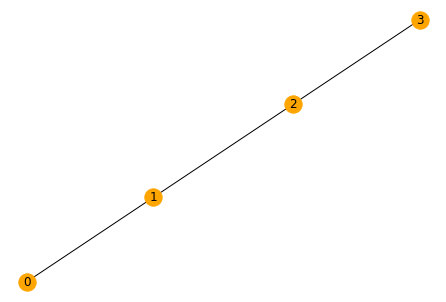

In [28]:
graph1 = nx.Graph()
graph1.add_edges_from([(0,1),(1,2),(2,3)])
nx.draw(graph1,with_labels=True,node_color='orange')

In [29]:
graph1 = fromNetworkxGraph(graph1)

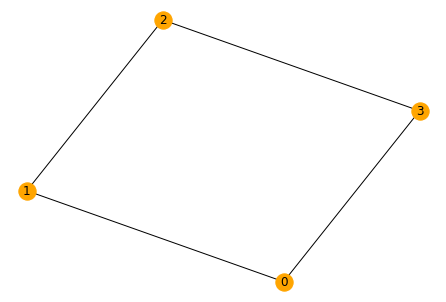

In [30]:
graph2 = nx.Graph()
graph2.add_edges_from([(0,1),(1,2),(2,3),(3,0)])
nx.draw(graph2,with_labels=True,node_color='orange')

In [31]:
graph2 = fromNetworkxGraph(graph2)

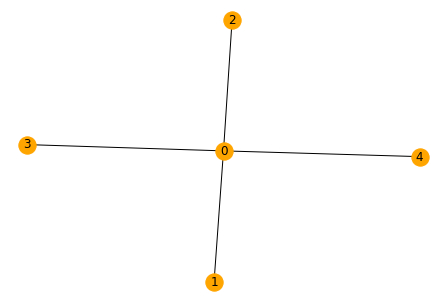

In [32]:
graph3 = nx.Graph()
graph3.add_edges_from([(0,1),(0,2),(0,3),(0,4)])
nx.draw(graph3, with_labels=True, node_color = 'orange')

In [33]:
graph3 = fromNetworkxGraph(graph3)

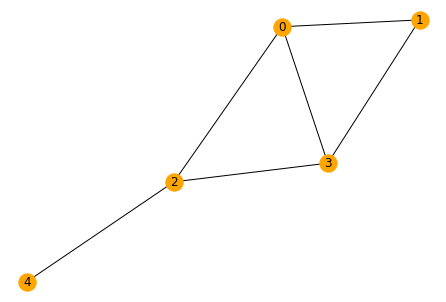

In [34]:
graph4 = nx.Graph()
graph4.add_edges_from([(0,1),(0,2),(0,3),(1,3),(2,4),(2,3)])
nx.draw(graph4, with_labels=True, node_color = 'orange')

In [35]:
graph4 = fromNetworkxGraph(graph4)

## Degree

Note that in this case the indegree is equal to outdegree as the directed graph is obtained from an original undirected graph

In [36]:
degrank = g.in_degree()

### Toy Example

{0: 1, 1: 2, 2: 2, 3: 1}

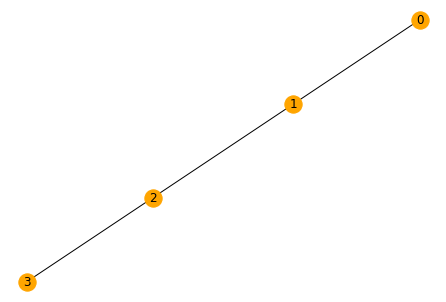

In [37]:
nx.draw(graph1.to_networkx_graph(),with_labels=True, node_color = 'orange')
graph1.in_degree()

{0: 2, 1: 2, 2: 2, 3: 2}

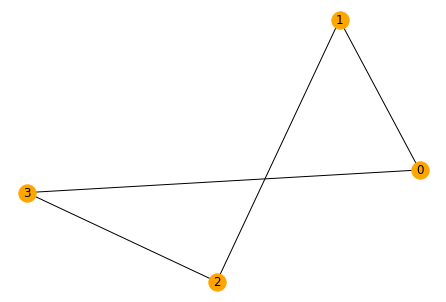

In [38]:
nx.draw(graph2.to_networkx_graph(),with_labels=True, node_color = 'orange')
graph2.in_degree()

{0: 4, 1: 1, 2: 1, 3: 1, 4: 1}

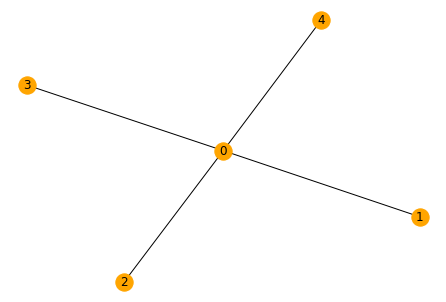

In [39]:
nx.draw(graph3.to_networkx_graph(),with_labels=True, node_color = 'orange')
graph3.in_degree()

### Degree distribution

In [40]:
degree = list(degrank.values())

In [41]:
print('DEGREE')
print('Mean degree: {}'.format(np.mean(degree)))
print('Standard deviation: {}'.format(np.std(degree)))
print('Median: {}'.format(np.median(degree)))
print('Min: {}'.format(np.min(degree)))
print('Max: {}'.format(np.max(degree)))

DEGREE
Mean degree: 9.912225931297252
Standard deviation: 21.180225766657404
Median: 5.0
Min: 0
Max: 865


In [42]:
#Build the equivalent Erdos-Renyi random graph of our istance of ActorGraph
random_graph = nx.fast_gnp_random_graph(g.getorder(),g.density())

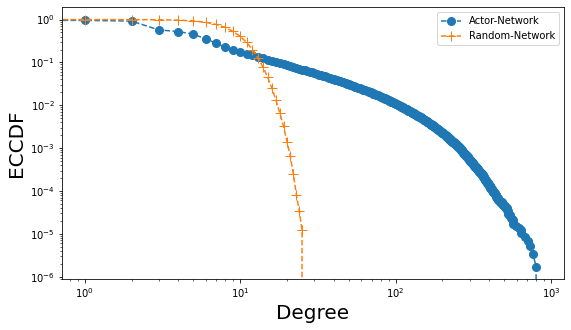

In [43]:
#Plot the Empirical Complementary Cumulative Distribution Function of 
#the degree distribution of our ActorGraph and the equivalent random network on log-log scale
random_degree = list(dict(random_graph.degree()).values())
cdf = ECDF(degree)
x = np.unique(degree)
y = cdf(x)

cdf_random = ECDF(random_degree)
x_random = np.unique(random_degree)
y_random = cdf_random(x_random)

fig_cdf = plt.figure(figsize=(9,5))
axes = fig_cdf.gca()
axes.set_xscale('log')
axes.set_yscale('log')
axes.loglog(x,1-y,marker='o',ms=8, linestyle='--',label='Actor-Network')
axes.loglog(x_random,1-y_random,marker='+',ms=10, linestyle='--',label='Random-Network')
axes.set_xlabel('Degree',size=20)
axes.set_ylabel('ECCDF', size = 20)
axes.legend()
plt.savefig('degree-distribution.pdf')
plt.show()

In [44]:
del random_degree
del degree
del random_graph
del cdf
del x
del y
del cdf_random
del x_random
del y_random
del fig_cdf
del axes
gc.collect()

19610

## PageRank

In [45]:
def pagerank(\
             graph,beta=0.85,epsilon=0.000001,\
             max_iter=100,\
             convergence_measure = lambda x,y: np.sum(np.abs(x-y))\
             ):
  """Returns the PageRank of the nodes in the graph.

  PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links. It was originally designed as an algorithm to rank web pages.

  Parameters
  ----------
  graph : ActorGraph
    Graph in a which a node is an actor and an edge will link two nodes if the corresponding actors played at least once in the same movie
  beta: int, optional
    Dumping factor for PageRank
  epsilon: float, optional
    Error tolerance used to check convergence in power method solver.
  max_iter: int, optional
    Maximum number of iterations in power method eigenvalue solver.
  convergence_measure: Callable[[np.array,np.array],float]
    Measure used to check convergence in power method solver.

  Returns
  -------
  Dict[int,float]
    Dictionary of nodes with PageRank as value.
  """

  def single_step(graph,n,v,p,beta=0.85):
    dangling_contribution = beta * sum([p[i] for i in graph.dangling]) / n
    for i in range(n):
      v[i] = (beta*sum([(p[j]/graph.out_degree[j])\
                       for j in graph.in_links[i]]))\
                       + dangling_contribution \
                       + ((1-beta) * (1/n))
    return v/np.sum(v)

  n = graph.getorder()
  v = np.zeros(n,dtype=np.float32)
  p = np.ones(n,dtype=np.float32)/n
  iter = 1
  convergence_rate = 1

  while convergence_rate >= epsilon and iter < max_iter:
    pfirst = single_step(graph,n,v,p,beta)
    convergence_rate = convergence_measure(p,pfirst)
    p = pfirst
    iter += 1

  return dict((k,v) for k,v in enumerate(p))

### Toy Example

{0: 0.17543857, 1: 0.32456145, 2: 0.32456145, 3: 0.17543857}

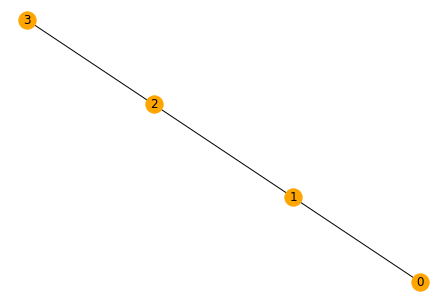

In [46]:
nx.draw(graph1.to_networkx_graph(),with_labels=True, node_color = 'orange')
pagerank(graph1)

{0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}

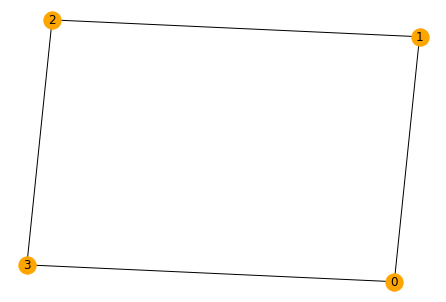

In [47]:
nx.draw(graph2.to_networkx_graph(),with_labels=True, node_color = 'orange')
pagerank(graph2)

{0: 0.47567585, 1: 0.13108103, 2: 0.13108103, 3: 0.13108103, 4: 0.13108103}

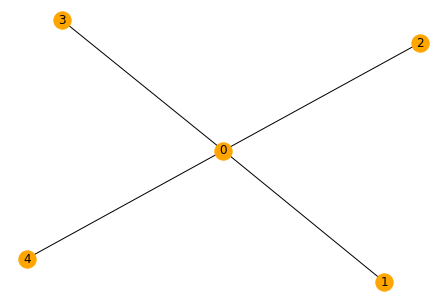

In [48]:
nx.draw(graph3.to_networkx_graph(),with_labels=True, node_color = 'orange')
pagerank(graph3)

### Empirical performance evaluation


In [49]:
gc.collect()

7037

In [50]:
from time import time

type(time())

float

In [51]:
#Measure the performance (time in seconds) of my PageRank algorithm and Networkx PageRank
#For different Barabasi-Albert graph of different order (from 1000 up to 500_000 nodes)
#For different Erdos-Renyi random graph of different density(from 1e-06 up to 1e-03)
#Save the performance measures in a Dict[str,List(float)] in which keys are the label for the experiments
#Values are the performance measures
#Save performance records in txt files during the execution
from time import time

times = {
    'numNodes': [],
    'density' : [],
}

N = 100_000
K = 9
EPSILON = 0.1

# (Number of Nodes, Density)
dataset = [
           (1000, 0.000001),
           (10_000, 0.00001),
           (50_000, 0.0001),
           (100_000, 0.00025),
           (200_000, 0.0005),
           (350_000, 0.00075),
           (500_000, 0.001)
]

for n,p in dataset:

  print(f"n {n} start")

  scalefree_random_net = nx.barabasi_albert_graph(n,K)
  tollerance = EPSILON / n #See the nx pagerank implementation to understand this operation
  t0 = time()
  pr = nx.pagerank(scalefree_random_net,alpha = 0.85, max_iter = 100, tol = tollerance)
  t1 = time()

  del pr
  gc.collect()

  nxtime = t1-t0
  scalefree_my_random = fromNetworkxGraph(scalefree_random_net)

  del scalefree_random_net
  gc.collect()

  t0 = time()
  pr = pagerank(scalefree_my_random,beta=0.85, max_iter = 100, epsilon = EPSILON)
  t1 = time()

  del pr
  gc.collect()

  mytime = t1-t0

  del scalefree_my_random
  gc.collect()

  print(f"{n}: nx: {nxtime}, mypr: {mytime}")
  times['numNodes'].append((n,nxtime,mytime))
  with open('ntimes.txt','a') as f:
    f.write(f"{n},{nxtime},{mytime}\n")
  print(f"{n} end\n")

  print(f"p {p} start")

  randomgraph = nx.fast_gnp_random_graph(N,p)
  tollerance = EPSILON / N #See the nx pagerank implementation to understand this operation
  t0 = time()
  pr = nx.pagerank(randomgraph,tol = tollerance)
  t1 = time()
  
  del pr
  gc.collect()

  nxtime = t1-t0
  myrandomgraph = fromNetworkxGraph(randomgraph)

  del randomgraph
  gc.collect()

  t0 = time()
  pr = pagerank(myrandomgraph,epsilon = EPSILON)
  t1 = time()

  del pr
  gc.collect()

  mytime = t1-t0

  del myrandomgraph
  gc.collect()

  print(f"p: nx: {nxtime}, mypr: {mytime}")
  times['density'].append((p,nxtime,mytime))  
  with open('ptimes.txt','a') as f:
    f.write(f"{p},{nxtime},{mytime}\n")
  print(f"{p} end\n")

'\n#Measure the performance (time in seconds) of my PageRank algorithm and Networkx PageRank\n#For different Barabasi-Albert graph of different order (from 1000 up to 500_000 nodes)\n#For different Erdos-Renyi random graph of different density(from 1e-06 up to 1e-03)\n#Save the performance measures in a Dict[str,List(float)] in which keys are the label for the experiments\n#Values are the performance measures\n#Save performance records in txt files during the execution\nfrom time import time\n\ntimes = {\n    \'numNodes\': [],\n    \'density\' : [],\n}\n\nN = 100_000\nK = 9\nEPSILON = 0.1\n\n# (Number of Nodes, Density)\ndataset = [\n           (1000, 0.000001),\n           (10_000, 0.00001),\n           (50_000, 0.0001),\n           (100_000, 0.00025),\n           (200_000, 0.0005),\n           (350_000, 0.00075),\n           (500_000, 0.001)\n]\n\nfor n,p in dataset:\n\n  print(f"n {n} start")\n\n  scalefree_random_net = nx.barabasi_albert_graph(n,K)\n  tollerance = EPSILON / n #See 

In [52]:
with open('times.json','w') as f:
  json.dump(times, f, indent = 4)

"\nwith open('times.json','w') as f:\n  json.dump(times, f, indent = 4)\n"

In [53]:
"""
with open('times.json','r') as f:
  times = json.load(f)
"""

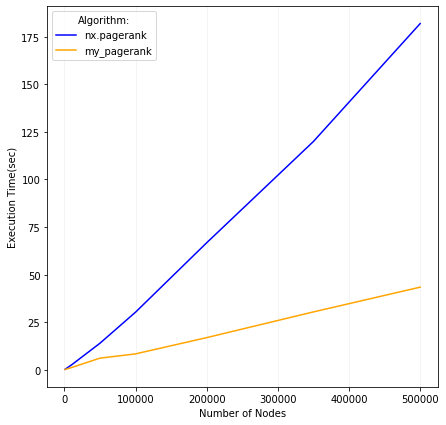

In [54]:
#Plot execution time of my pagerank and nx pagerank in function of number of nodes in the graph
xnodes = np.array([row[0] for row in times['numNodes']])
ypr = np.array([row[1] for row in times['numNodes']]) 
ymy = np.array([row[2] for row in times['numNodes']]) 

plt.figure(figsize=(7,7))
plt.plot(xnodes, ypr, color='blue', label='nx.pagerank')
plt.plot(xnodes, ymy, color='orange', label='my_pagerank')
plt.grid(axis='x', color='0.95')
plt.legend(title='Algorithm:')
plt.xlabel('Number of Nodes')
plt.ylabel('Execution Time(sec)')
plt.savefig('time_for_nodes.pdf')
plt.show()

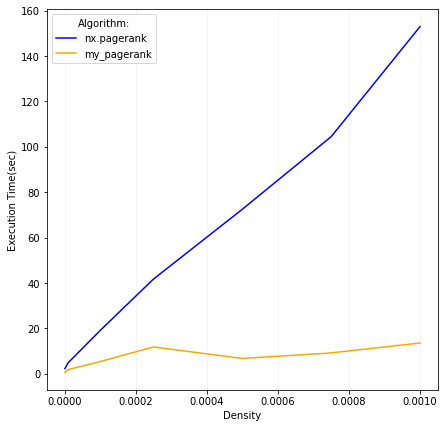

In [55]:
#Plot execution time of my pagerank and nx pagerank in function of density of the graph
xdensity = np.array([row[0] for row in times['density']])
ypr = np.array([row[1] for row in times['density']]) 
ymy = np.array([row[2] for row in times['density']]) 

plt.figure(figsize=(7,7))
plt.plot(xdensity, ypr, color='blue', label='nx.pagerank')
plt.plot(xdensity, ymy, color='orange', label='my_pagerank')
plt.grid(axis='x', color='0.95')
plt.legend(title='Algorithm:')
plt.xlabel('Density')
plt.ylabel('Execution Time(sec)')
plt.savefig('time_for_density.pdf')
plt.show()

### Convergence experiments

In [56]:
def test_pagerank(\
             graph,beta=0.85,epsilon=None,\
             max_iter=100,\
             convergence_measure = lambda x,y: np.sum(np.abs(x-y))\
             ):
  """Method used to test convergence of power iteration method for PageRank.
  Returns the pagerank of the nodes, the number of iterations performed, a list of convergence rates.

  Parameters
  ----------
  graph : ActorGraph
    Graph in a which a node is an actor and an edge will link two nodes if the corresponding actors played at least once in the same movie
  beta: int, optional
    Dumping factor for PageRank
  epsilon: float, optional
    Error tolerance used to check convergence in power method solver. 
    If epsilon is None the method continue until max_iter.
  max_iter: int, optional
    Maximum number of iterations in power method eigenvalue solver.
  convergence_measure: Callable[[np.array,np.array],float]
    Measure used to check convergence in power method solver.

  Returns
  -------
  Tuple[np.array,int,List[float]]
   Pagerank of the nodes, the number of iterations performed, list of convergence rates.
  """
  def single_step(graph,n,v,p,beta=0.85):
    dangling_contribution = beta * sum([p[i] for i in graph.dangling]) / n
    for i in range(n):
      v[i] = (beta*sum([(p[j]/graph.out_degree[j])\
                       for j in graph.in_links[i]]))\
                       + dangling_contribution \
                       + ((1-beta) * (1/n))
    return v/np.sum(v)

  n = graph.getorder()
  v = np.zeros(n,dtype=np.float32)
  p = np.ones(n,dtype=np.float32)/n
  iter = 1
  convergence_rate = 1
  
  convrates = []

  while iter <= max_iter:
    pfirst = single_step(graph,n,v,p,beta)
    convergence_rate = convergence_measure(p,pfirst)
    p = pfirst
    iter += 1

    convrates.append(convergence_rate)
    if epsilon is not None and convergence_rate <= epsilon: break

  return p, (iter-1), convrates

In [57]:
l1 = lambda x,y: np.sum(np.abs(x-y))
_,_,convrates = test_pagerank(g)

In [58]:
l2 = lambda x,y : np.sum(np.power((x-y),2))
_,_,convl2 = test_pagerank(g,convergence_measure = l2)

In [59]:
magnitudemax = lambda x,y: max(np.abs(x-y))
_,_,convmax = test_pagerank(g,convergence_measure = magnitudemax)

In [60]:
x = np.array(range(1,101,1))

yl1 = np.array(convrates)
yl2 = np.array(convl2)
ymax = np.array(convmax)

'\nx = np.array(range(1,101,1))\n\nyl1 = np.array(convrates)\nyl2 = np.array(convl2)\nymax = np.array(convmax)\n'

In [61]:
convs = {
    'l1': list(map(lambda x: str(x),convrates)),
    'l2': list(map(lambda x: str(x),convl2)),
    'max': list(map(lambda x: str(x),convmax))
}

"\nconvs = {\n    'l1': list(map(lambda x: str(x),convrates)),\n    'l2': list(map(lambda x: str(x),convl2)),\n    'max': list(map(lambda x: str(x),convmax))\n}\n"

In [62]:
with open('convergence.json','w') as f:
  json.dump(convs,f,indent=4)

"\nwith open('convergence.json','w') as f:\n  json.dump(convs,f,indent=4)\n"

In [63]:
"""
with open('convergence.json','r') as f:
  convs = json.load(f)
  convs = dict([(k,list(map(lambda x: np.float32(x),v))) for k,v in convs.items()])
  x = range(1,101,1)
  yl1 = np.array(convs['l1'])
  yl2 = np.array(convs['l2'])
  ymax = np.array(convs['max'])
"""

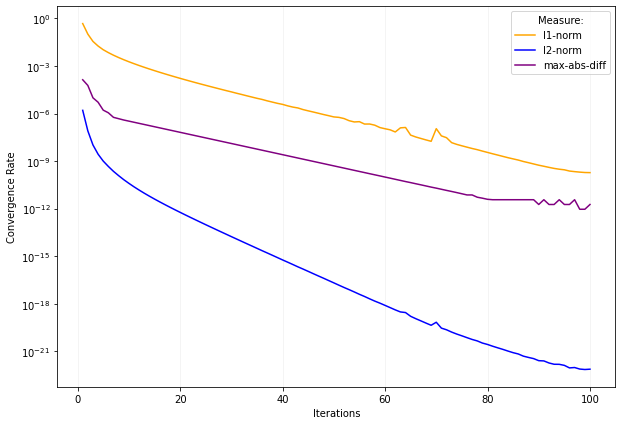

In [64]:
#Plot the convergence_rate for different measures (l1-norm,l2-norm,max-abs-diff) in function of iterations for the ActorGraph
plt.figure(figsize=(10,7))
plt.plot(x, yl1, color='orange',label = 'l1-norm')
plt.plot(x, yl2, color='blue',label = 'l2-norm')
plt.plot(x, ymax, color = 'purple', label = 'max-abs-diff')
plt.grid(axis='x', color='0.95')
plt.legend(title='Measure:')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Convergence Rate')
plt.savefig('convergence_per_iteration.pdf')
plt.show()

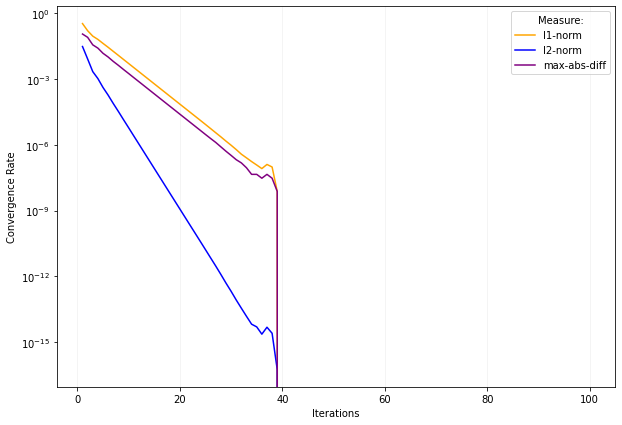

In [65]:
#Plot the convergence_rate for different measures (l1-norm,l2-norm,max-abs-diff) in function of iterations for a toy graph
plt.figure(figsize=(10,7))
x = np.arange(1,101,1)

for c,n,m in zip(['orange','blue','purple'],['l1-norm','l2-norm','max-abs-diff'],[l1,l2,magnitudemax]):
  _,_,rates = test_pagerank(graph4,convergence_measure = m)
  y = np.array(rates)
  plt.plot(x, y, color=c,label = n)

plt.grid(axis='x', color='0.95')
plt.legend(title='Measure:')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Convergence Rate')
plt.savefig('toy_convergence_per_iteration.pdf')
plt.show()

### Topic Sensitive PageRank

In [66]:
def tsrank(\
           graph,beta=0.85,\
           topic = None,\
           epsilon=0.000001,\
           max_iter=100,\
           convergence_measure = lambda x,y: np.sum(np.abs(x-y))\
           ):
  """Returns the Topic-Sensitive PageRank of the nodes in the graph.

  Parameters
  ----------
  graph : ActorGraph
    Graph in a which a node is an actor and an edge will link two nodes if the corresponding actors played at least once in the same movie.
  beta: int, optional
    Dumping factor for PageRank.
  topic : List[bool]
    List in which for each node there is 1 if the node is on topic and 0 otherwise.
  epsilon: float, optional
    Error tolerance used to check convergence in power method solver.
  max_iter: int, optional
    Maximum number of iterations in power method eigenvalue solver.
  convergence_measure: Callable[[np.array,np.array],float]
    Measure used to check convergence in power method solver.

  Returns
  -------
  Dict[int,float]
    Dictionary of nodes with Topic-Sensitive PageRank as value.
  """
  def single_step(graph,n,v,p,topic, ontopic, beta=0.85):
    dangling_contribution = beta * sum([p[i] for i in graph.dangling]) / n
    for i in range(n):
      v[i] = (beta*sum([(p[j]/graph.out_degree[j])\
                       for j in graph.in_links[i]]))\
                       +  dangling_contribution\
                       + ((1-beta) * topic[i] * (1/ontopic))
    return v/np.sum(v)

  n = graph.getorder()
  v = np.zeros(n,dtype=np.float32)
  p = np.ones(n,dtype=np.float32)/n
  iter = 1
  convergence_rate = 1

  if topic is None:
    topic = np.ones(n,dtype=np.float32)
  
  ontopic = sum(topic)

  while convergence_rate > epsilon and iter < max_iter:
    pfirst = single_step(graph,n,v,p,topic,ontopic,beta)
    convergence_rate = convergence_measure(p,pfirst)
    p = pfirst
    iter += 1

  return dict((k,v) for k,v in enumerate(p))

In [67]:
%time genderrank = tsrank(g, epsilon = 0.000001 * g.getorder(), topic=list(g.genderAttribute.values()))

CPU times: user 6.95 s, sys: 10.8 ms, total: 6.96 s
Wall time: 6.99 s


In [68]:
sum(genderrank.values())

1.0000000848726707

## HITS

In [69]:
def hits(graph,iterations=100):

  """Returns hub and authority values for each node in the graph.

  Parameters
  -----------
  graph: ActorGraph
    Graph in a which a node is an actor and an edge will link two nodes if the corresponding actors played at least once in the same movie.
  iterations: int, optional
    Number of iterations for authority and hub values update.
    
  Returns
  -----------
  hub,auth : Tuple[Dict[int,float],Dict[int,float]]
    Tuple of dicts in which are stored for each node the corresponding hub and authority value
  """

  auth = dict([(k,1) for k in graph.nodes()])
  hub = dict([(k,1) for k in graph.nodes()])

  for _ in range(iterations):

    #auth update
    for i in auth:
      auth[i] = sum([hub[j] for j in graph.in_links[i]])

    #hub update
    for i in hub:
      hub[i] = sum([auth[j] for j in graph.out_links[i]])

    #normalization
    authfactor = sum(auth.values()) 
    hubfactor = sum(hub.values())
    auth = {k: (v/authfactor) for k,v in auth.items()}
    hub = {k: (v/hubfactor) for k,v in hub.items()}

  return hub, auth

### Toy Example

In [70]:
def print_hub_auth(hubauth):
  "Utility to print hub and auth dict in a more understandable way"
  hub,auth = hubauth
  print(f"Hub: {hub}\nAuth: {auth}")

Hub: {0: 0.19098300562505258, 1: 0.30901699437494745, 2: 0.30901699437494745, 3: 0.19098300562505258}
Auth: {0: 0.19098300562505258, 1: 0.3090169943749474, 2: 0.3090169943749474, 3: 0.19098300562505258}


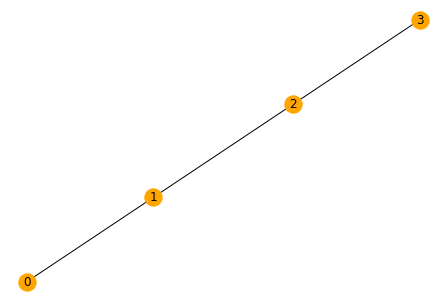

In [71]:
nx.draw(graph1.to_networkx_graph(),with_labels=True, node_color = 'orange')
print_hub_auth(hits(graph1))

Hub: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
Auth: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}


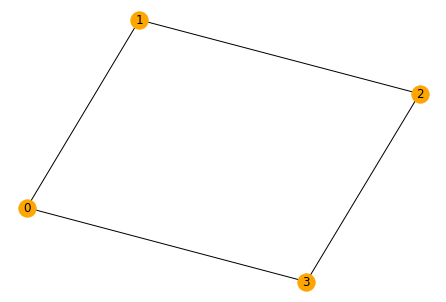

In [72]:
nx.draw(graph2.to_networkx_graph(),with_labels=True, node_color = 'orange')
print_hub_auth(hits(graph2))

Hub: {0: 0.2, 1: 0.2, 2: 0.2, 3: 0.2, 4: 0.2}
Auth: {0: 0.5000000000000001, 1: 0.12500000000000003, 2: 0.12500000000000003, 3: 0.12500000000000003, 4: 0.12500000000000003}


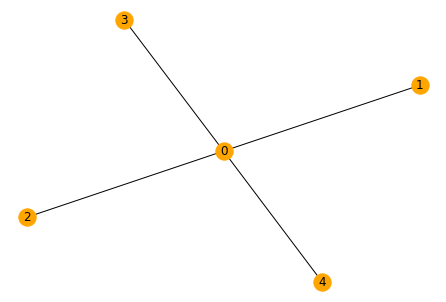

In [73]:
nx.draw(graph3.to_networkx_graph(),with_labels=True, node_color = 'orange')
print_hub_auth(hits(graph3))

# Ranks comparison

## Top10 of each rank

In [74]:
degrank = g.in_degree()

In [75]:
top10degrank = sorted(degrank.items(), key=lambda x: x[1],reverse=True)[:10]
top10degrank

[(128033, 865),
 (58225, 801),
 (44022, 764),
 (55814, 732),
 (39605, 714),
 (63926, 677),
 (53066, 643),
 (62749, 639),
 (65739, 618),
 (40369, 591)]

In [76]:
prank = pagerank(g)

In [77]:
with open('pagerank.json','w') as f:
  toSave = dict([(k,str(v)) for k,v in prank.items()])
  json.dump(toSave,f,indent=4)

"\nwith open('pagerank.json','w') as f:\n  toSave = dict([(k,str(v)) for k,v in prank.items()])\n  json.dump(toSave,f,indent=4)\n"

In [78]:
"""
with open('pagerank.json','r') as f:
  fromDump = json.load(f)
  prank = dict([(k,np.float32(v)) for k,v in fromDump.items()])
"""

In [79]:
top10prank = sorted(prank.items(), key=lambda x: x[1],reverse=True)[:10]
top10prank

[('55814', 0.00011188644),
 ('128033', 8.1640865e-05),
 ('39605', 7.1438546e-05),
 ('58225', 6.927196e-05),
 ('73431', 5.9934355e-05),
 ('74407', 5.8757323e-05),
 ('77974', 5.8360736e-05),
 ('240271', 5.8137513e-05),
 ('67625', 5.6825273e-05),
 ('91103', 5.4326276e-05)]

In [80]:
genderrank = tsrank(g,topic=list(g.genderAttribute.values()))

In [81]:
with open('topic-sensitive-rank.json','w') as f:
  toSave = dict([(k,str(v)) for k,v in genderrank.items()])
  json.dump(toSave,f,indent=4)

"\nwith open('topic-sensitive-rank.json','w') as f:\n  toSave = dict([(k,str(v)) for k,v in genderrank.items()])\n  json.dump(toSave,f,indent=4)\n"

In [82]:
"""
with open('topic-sensitive-rank.json','r') as f:
  fromDump = json.load(f)
  genderrank = dict([(k,np.float32(v)) for k,v in fromDump.items()])
"""

In [83]:
top10genderrank = sorted(genderrank.items(), key=lambda x: x[1],reverse=True)[:10]
top10genderrank

[('55814', 0.00012122903),
 ('39605', 0.00011293084),
 ('58225', 9.56341e-05),
 ('240271', 9.4752286e-05),
 ('128033', 7.787699e-05),
 ('151542', 6.853794e-05),
 ('65087', 6.853214e-05),
 ('65739', 6.818579e-05),
 ('49539', 6.6550114e-05),
 ('56700', 6.584853e-05)]

In [84]:
hubrank, authrank = hits(g,iterations=60)

In [85]:
with open('auth-rank.json','w') as f:
  toSave = dict([(k,str(v)) for k,v in authrank.items()])
  json.dump(toSave,f,indent=4)
  f.close()

with open('hub-rank.json','w') as f1:
  toSave1 = dict([(k,str(v)) for k,v in hubrank.items()])
  json.dump(toSave1,f1,indent=4)

"\nwith open('auth-rank.json','w') as f:\n  toSave = dict([(k,str(v)) for k,v in authrank.items()])\n  json.dump(toSave,f,indent=4)\n  f.close()\n\nwith open('hub-rank.json','w') as f1:\n  toSave1 = dict([(k,str(v)) for k,v in hubrank.items()])\n  json.dump(toSave1,f1,indent=4)\n"

In [86]:
"""
with open('auth-rank.json','r') as f:
  fromDump = json.load(f)
  authrank = dict([(k,np.float32(v)) for k,v in fromDump.items()])
  f.close()

with open('hub-rank.json','r') as f1:
  fromDump1 = json.load(f1)
  hubrank = dict([(k,np.float32(v)) for k,v in fromDump1.items()])
"""

In [87]:
top10hubrank = sorted(hubrank.items(), key=lambda x: x[1],reverse=True)[:10]
top10authrank = sorted(authrank.items(), key=lambda x: x[1],reverse=True)[:10]
top10authrank

[('40369', 0.002510891),
 ('29406', 0.002379203),
 ('18370', 0.002339439),
 ('28925', 0.002301597),
 ('26928', 0.0022637667),
 ('36296', 0.0022128674),
 ('29278', 0.002211824),
 ('22466', 0.0021162122),
 ('35689', 0.0020780796),
 ('24566', 0.0020737688)]

In [88]:
nxg = g.to_networkx_graph()

In [89]:
top10hrank = [(k,v) for k,v in nx.harmonic_centrality(nxg,nbunch=top10id.keys()).items()]
top10hrank

[(14709, 101559.97298517855),
 (26636, 107205.3959787793),
 (14740, 103095.9291151237),
 (15819, 100351.34953640647),
 (27235, 103289.42753058544),
 (15810, 103148.44960852368),
 (15014, 106052.94185235315),
 (41673, 110977.15045206077),
 (32047, 108142.15788351704),
 (57485, 106345.61152710133)]

In [90]:
def who_are(nodes):
  """Returns (name,rankvalue) pairs for the actors in nodes sorted by rankvalue in descending order.

  Parameters
  -----------
  nodes: List[Tuple[int,float]]
    list of (nodeid,rankValue) pairs.
  
  Returns
  ----------
  List[Tuple[str,"int or float"]]
    (name,rankvalue) pairs for the actors in nodes sorted by rankvalue in descending order
  """
  with open('id-actor.json','r') as f:
    actordict = json.load(f)
    actors = dict([(actordict[str(k)],v) for k,v in nodes])
    del actordict
    gc.collect()
    f.close()
  with open('name.basics.tsv/name.basics.tsv','r') as tsv_file:
    tsv = csv.reader(tsv_file,delimiter="\t")
    header = next(tsv)
    end = False
    names = []
    N = len(nodes)
    while not end and len(names)<N:
      try:
        row = next(tsv)
      except StopIteration:
        end = True
      else:
        #['nconst','primaryName','birthYear','deathYear','primaryProfession','knownForTitles']
        if row[0] in actors:
          names.append((row[1],actors[row[0]]))
    del tsv
    gc.collect()
    tsv_file.close()
  return sorted(names,key=lambda x: x[1],reverse=True)

In [91]:
names_degrank = who_are(top10degrank)

In [92]:
names_prank = who_are(top10prank)

In [93]:
names_tsrank = who_are(top10genderrank)

In [94]:
names_hubrank = who_are(top10hubrank)

In [95]:
names_authrank = who_are(top10authrank)

In [96]:
def getOnlyNames(rank):
  """Returns names of the actors in rank"""
  return [name for name,value in rank]

### Rank Table

In [97]:
ranks = pd.DataFrame()
ranks['In-Degree'] = getOnlyNames(names_degrank)
ranks['PageRank'] = getOnlyNames(names_prank)
ranks['Ts-PageRank'] = getOnlyNames(names_tsrank)
ranks['HITS-Hub'] = getOnlyNames(names_hubrank)
ranks['HITS-Auth'] = getOnlyNames(names_authrank)
ranks.index += 1

In [98]:
ranks

,In-Degree,PageRank,Ts-PageRank,HITS-Hub,HITS-Auth
1,Brahmanandam,Eric Roberts,Eric Roberts,Aruna Irani,Aruna Irani
2,Ron Jeremy,Brahmanandam,Masayoshi Nogami,Helen,Helen
3,Eddie Garcia,Masayoshi Nogami,Ron Jeremy,Ashok Kumar,Ashok Kumar
4,Eric Roberts,Ron Jeremy,Seiji Nakamitsu,Master Bhagwan,Master Bhagwan
5,Masayoshi Nogami,Joe Estevez,Brahmanandam,Pran,Pran
6,Paquito Diaz,Michael Madsen,Kôji Makimura,Dharmendra,Dharmendra
7,Mithun Chakraborty,Tom Sizemore,Yutaka Ikejima,Jagdeep,Jagdeep
8,Shakti Kapoor,Seiji Nakamitsu,Tom Byron,Jeevan,Jeevan
9,Tom Byron,Tony Devon,Jamie Gillis,Mohan Choti,Mohan Choti
10,Aruna Irani,Danny Trejo,Jean-Pierre Armand,Madan Puri,Madan Puri


## Top10 of all time similarity

### Preliminaries

In [99]:
def retrieveRankBestActors(rank,top10):
  """Returns the rank of the best actor and actresses of all time by IMDB according to the rank parameter.

  Parameters
  -----------
  rank: Dict["int or str",float]
    Dictiornary in which for each nodeid is stored a rank value according to same strategy(PageRank,HITS,...)
  top10: Dict[int,str]
    Dictionary in which are stored (nodeid,actorName) relations for the best actors and actresses of all time by IMDB

  Returns
  -----------
  List[Tuple[str,"int or float"]]
    List of (actorName,rankValue) pairs sorted by rankValue in descending order.
  """
  rank = dict([(int(k),v) for k,v in rank.items()])
  rankBest = []
  for actor,value in rank.items():
    if actor in top10:
      rankBest.append((top10[actor],value))
    if rankBest == len(top10): break
  return sorted(rankBest,key=lambda x: x[1],reverse=True)

In [100]:
top10actorIMBD

['Katharine Hepburn',
 'Jack Nicholson',
 'Laurence Olivier',
 'Meryl Streep',
 'Humphrey Bogart',
 'Audrey Hepburn',
 'Robert De Niro',
 'Bette Davis',
 'Cary Grant',
 'Marlon Brando']

In [101]:
top_with_deg = retrieveRankBestActors(degrank,top10id)
top_with_deg

[('Robert De Niro', 224),
 ('Bette Davis', 199),
 ('Cary Grant', 171),
 ('Humphrey Bogart', 166),
 ('Meryl Streep', 144),
 ('Jack Nicholson', 137),
 ('Laurence Olivier', 131),
 ('Katharine Hepburn', 111),
 ('Marlon Brando', 111),
 ('Audrey Hepburn', 62)]

In [102]:
top_with_pr = retrieveRankBestActors(prank,top10id)
top_with_pr

[('Robert De Niro', 2.4316249e-05),
 ('Meryl Streep', 1.6213675e-05),
 ('Jack Nicholson', 1.4998927e-05),
 ('Bette Davis', 1.3288857e-05),
 ('Cary Grant', 1.0749847e-05),
 ('Laurence Olivier', 1.0710573e-05),
 ('Humphrey Bogart', 1.0283245e-05),
 ('Marlon Brando', 1.0226178e-05),
 ('Katharine Hepburn', 8.281349e-06),
 ('Audrey Hepburn', 5.3749172e-06)]

In [103]:
top_with_ts = retrieveRankBestActors(genderrank,top10id)
top_with_ts

[('Robert De Niro', 2.4992527e-05),
 ('Meryl Streep', 1.7349035e-05),
 ('Jack Nicholson', 1.645434e-05),
 ('Bette Davis', 1.4833126e-05),
 ('Cary Grant', 1.1612548e-05),
 ('Laurence Olivier', 1.1024845e-05),
 ('Humphrey Bogart', 1.0812544e-05),
 ('Marlon Brando', 1.0738031e-05),
 ('Katharine Hepburn', 8.848231e-06),
 ('Audrey Hepburn', 6.2916442e-06)]

In [104]:
top_with_hub = retrieveRankBestActors(hubrank,top10id)
top_with_hub

[('Robert De Niro', 7.97865e-07),
 ('Meryl Streep', 7.9061573e-07),
 ('Jack Nicholson', 4.9817584e-07),
 ('Laurence Olivier', 3.8291824e-07),
 ('Bette Davis', 3.595209e-07),
 ('Audrey Hepburn', 3.4341633e-07),
 ('Marlon Brando', 2.3579842e-07),
 ('Humphrey Bogart', 1.7547826e-07),
 ('Cary Grant', 1.5404576e-07),
 ('Katharine Hepburn', 1.3111335e-07)]

In [105]:
top_with_auth = retrieveRankBestActors(authrank,top10id)
top_with_auth

[('Robert De Niro', 7.9785565e-07),
 ('Meryl Streep', 7.906074e-07),
 ('Jack Nicholson', 4.986056e-07),
 ('Laurence Olivier', 3.8292146e-07),
 ('Bette Davis', 3.5954398e-07),
 ('Audrey Hepburn', 3.4341963e-07),
 ('Marlon Brando', 2.3582342e-07),
 ('Humphrey Bogart', 1.7549273e-07),
 ('Cary Grant', 1.5405966e-07),
 ('Katharine Hepburn', 1.3112137e-07)]

In [106]:
top_with_harmonic = who_are(top10hrank)
top_with_harmonic

[('Robert De Niro', 110977.15045206077),
 ('Jack Nicholson', 108142.15788351704),
 ('Marlon Brando', 107205.3959787793),
 ('Meryl Streep', 106345.61152710133),
 ('Laurence Olivier', 106052.94185235315),
 ('Audrey Hepburn', 103289.42753058544),
 ('Katharine Hepburn', 103148.44960852368),
 ('Bette Davis', 103095.9291151237),
 ('Humphrey Bogart', 101559.97298517855),
 ('Cary Grant', 100351.34953640647)]

In [107]:
tops = [top_with_deg, top_with_pr, top_with_ts, top_with_hub, top_with_auth, top_with_harmonic]
tops = [getOnlyNames(top) for top in tops]
tops.insert(0,top10actorIMBD)

### Kendalltau similarity heatmap

In [108]:
from scipy.stats import kendalltau

def kendalltau_sim_matrix(vectors):
  """Returns similarity matrix according to kendalltau distance for vectors and the corresponding p_values matrix"""
  sim_matrix = np.zeros((len(vectors),len(vectors)))
  p_values = np.zeros((len(vectors),len(vectors)))
  for i,a in enumerate(vectors):
    for j,b in enumerate(vectors):
      sim_matrix[i][j], p_values[i][j] = kendalltau(a,b)
  return sim_matrix, p_values

In [109]:
sim , pvalues = kendalltau_sim_matrix(tops)
columns =  ['IMDB','Deg','PR','Ts-PR','Hub','Auth','Harmonic']
df = pd.DataFrame(sim,index = columns, columns = columns)

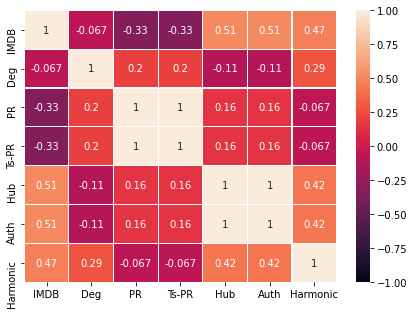

In [110]:
#Plot heatmap of kendalltau similarity matrix
plt.figure(figsize=(7,5))
sns.heatmap(df,vmin=-1,vmax=1,annot=True,linewidths=.2)
plt.savefig('kendalltau-heatmap.pdf')
plt.show()

In [111]:
print(f"IMBD-Harmonic p_value : {pvalues[0][6]}")
print(f"IMDB-Auth p_value: {pvalues[0][5]}")

IMBD-Harmonic p_value : 0.07255015432098766
IMDB-Auth p_value: 0.04662257495590829


### Hamming similarity heatmap

In [112]:
from scipy.spatial import distance

def hamming_sim_matrix(vectors):
  """Returns similarity matrix according to hamming distance for vectors."""
  sim_matrix = np.zeros((len(vectors),len(vectors)))
  for i,a in enumerate(vectors):
    for j,b in enumerate(vectors):
      sim_matrix[i][j] = 1 - distance.hamming(a,b)
  return sim_matrix

In [113]:
sim = hamming_sim_matrix(tops)
columns =  ['IMDB','Deg','PR','Ts-PR','Hub','Auth','Harmonic']
df = pd.DataFrame(sim,index = columns, columns = columns)

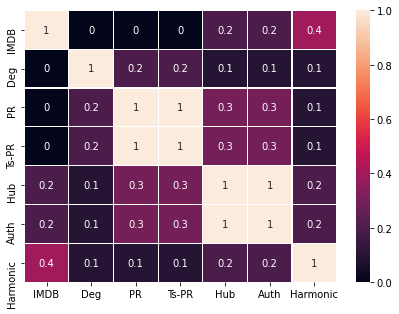

In [114]:
#Plot heatmap for hamming similarity matrix
plt.figure(figsize=(7,5))
sns.heatmap(df,vmin=0,vmax=1,annot=True,linewidths=.2)
plt.savefig('hamming-heatmap.pdf')
plt.show()